# TP Compressed Sensing for MR Images

Diana Mateus



Participants:

Tengfei HAN

Arthur METZGER

### GOAL
This notebook explores one of the most useful applications of compressed sensing, namely Magnetic Resonance Image (MRI) reconstruction. 

We will use the SigPy module, and this notebook is partly inspired on the module's tutorial. 

There will be two datasets to explore:

- The first is a controlled dataset for which we have a ground truth digital **phantom** image.
- The second is a multi-channel data from the ISMRM reproducible challenge (Source: Martin Uecker). The dataset contains k-space measurements of an **in-vivo brain** scan acquired with a projection reconstruction trajectory. 


### References

You can refer to the next links to search the answer of some of the questions

- An old but very useful site about the MR Imaging is https://www.mr-tip.com, here you will find definitions of all the MRI specific terms, the parallel acquisition and also of some of the methods. 

- A complete website about MRI in questions and answers http://mriquestions.com/complete-list-of-questions.html 

- The original scientific papers regarding the new methods (other than classical inv problems algorithms)

    - [Sense](https://www.physast.uga.edu/classes/phys8900/qzhao/PDF8500_08/SENSE.pdf)
    - [Espirit](https://onlinelibrary.wiley.com/doi/pdf/10.1002/mrm.24751)
    
- [SigPy documentation](https://sigpy.readthedocs.io) 

- Do not hesitate to find and cite your own sources (papers, blogs, tutorials or videos)

In [1]:
import os.path
if os.path.isfile('data/cartesian_ksp.npy'):
    cartesian_ksp_npy_path = 'data/cartesian_ksp.npy'
else:
    cartesian_ksp_npy_path = 'cartesian_ksp.npy'

### Requirements
Install the required module Sigpy and load modules and functions
    

In [2]:
#!pip install sigpy

#import sys
#!conda install --yes --prefix {sys.prefix} sigpy

#import sys
#!{sys.executable} -m pip install sigpy

In [3]:
import numpy as np
import sigpy as sp
import sigpy.plot as pl
import matplotlib.pyplot as plt
from math import log10, sqrt 
from sigpy.mri import poisson, spiral,radial
import sigpy.mri as mr



In [4]:
def multiChannelPhantomKspace(shape =(256,256), nchannels=1):

    #loading the logan phantom
    logan = sp.shepp_logan(shape)

    #copying the fft of the phantom on the different channels
    logan_multi = np.zeros((nchannels,shape[0],shape[1]),dtype=np.complex_)
    logan_multi_ksp = np.zeros((nchannels,shape[0],shape[1]),dtype=np.complex_)
    ksp = sp.fft(logan)
    
    for i in range(nchannels):
        logan_multi[i,:,:]= logan
        logan_multi_ksp[i,:,:]= ksp
    return logan_multi_ksp



In [5]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):    #  MSE is zero means no noise is present in the signal . 
        return -100  #  Therefore PSNR is irrelevant
    max_pixel = original.max()
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr 

## REPORT INSTRUCTIONS

Prepare a report following the **structure below** and answering to the questions **with your own words**

**Hint:** To answer some of the questions you will need to look within the references provided above: ``MRI Questions website`` (e.g. section K-space), you can also search for keywords (e.g. sensitivity, ESPIRIT) within the ``MRI-tip website``



## 1. Datasets

#### Load and display the k-space data

a) Visualize the **phantom** dataset with a single channel. 

In [6]:
#load phantom data

ksp_phantom = multiChannelPhantomKspace(nchannels=1)


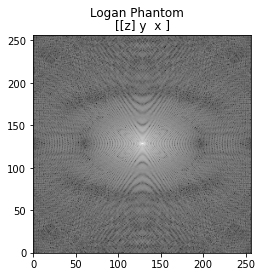

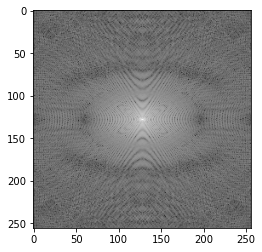

In [7]:
# Visualization
# Try both equivalent ways to display: using Sigpy ImagePlot or scikit image imshow

pl.ImagePlot(np.log(np.abs(ksp_phantom)+1e-16), z=0,title='Logan Phantom', interpolation="antialiased")

plt.imshow(np.log(np.abs(ksp_phantom[0,:,:]+1e-16)),cmap='gray', interpolation="antialiased") #adding a small value to prevent log(0)
plt.show()

`sp.ImagePlot` puts the origin 0,0 in the lower left and `plt.imshow` in the upper left.

b) Visualize the **invivo brain** dataset with multiple channels.

In [8]:
# load the in-vivo data
ksp = np.load(cartesian_ksp_npy_path)
print(ksp.shape)

(8, 230, 180)


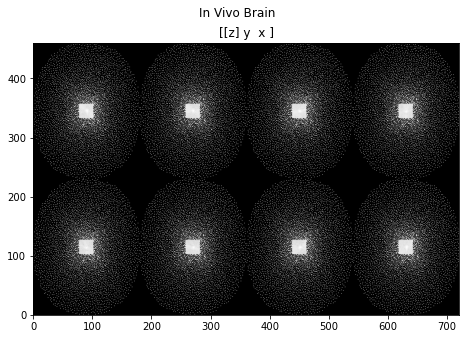

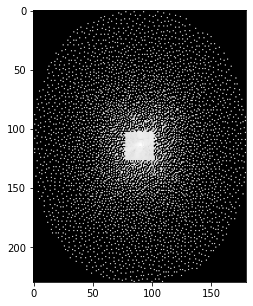

In [9]:
# Visualizing the invivo data
plt.rcParams["figure.figsize"] = (10,5)

# Fill in
pl.ImagePlot(np.log(np.abs(ksp)+1e-16), z=0, title='In Vivo Brain', interpolation="antialiased")

plt.imshow(np.log(np.abs(ksp[0,:,:]+1e-16)),cmap='gray', interpolation="antialiased") #adding a small value to prevent log(0)
plt.show()

c) What do the images show? What do the values in the K-Space stand for?

The phantom image is a created image, and its ksp displayed above is its Fourier transform.

The ksp of the in vivo brain displayed above is the result of measures stored into K-space.

The values in the K-space stand for the Fourier transform of the image of interest.

##  2. Reconstruction of the full phantom data



#### Direct reconstruction from full data

**2.1.** How do we reconstruct the MRI data from a single fully sampled k-space?

With an inverse Fourier transform

**2.2.** Implement and show the results of reconstructing the **phantom** image from the fully sampled data

1.94942303014338e-33


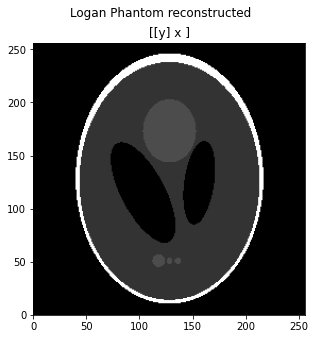

In [10]:
phantom_rec = sp.ifft(ksp_phantom[0,:,:], axes=(-1, -2))

print(np.var(np.imag(phantom_rec)))
phantom_rec = np.real(phantom_rec)

pl.ImagePlot(phantom_rec, title='Logan Phantom reconstructed', interpolation="antialiased")


#### Wavelet transform 

**2.3.** Compute the wavelet transform of the fully reconstructed image. Why is the wavelet transform a good choice for CS? demonstrate by showing the histogram of the wavelet coefficients ordered from the largest to the smallest.

(256, 256)
(288, 288)


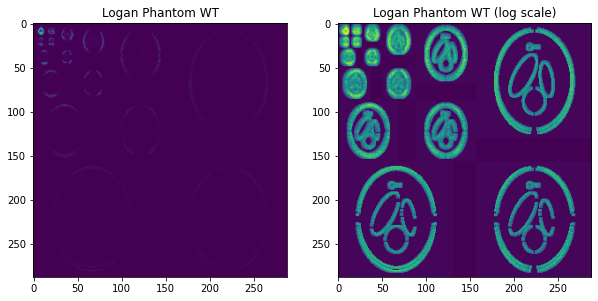

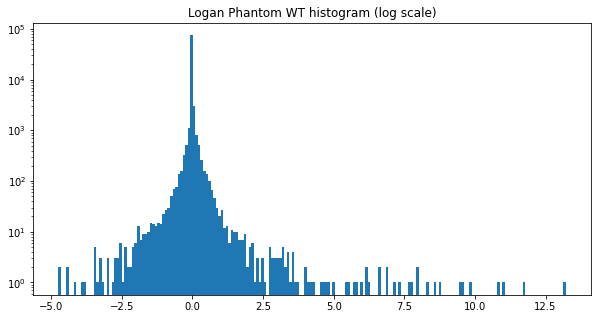

In [11]:
phantom_rec_wt = sp.fwt(phantom_rec, level=5)

print(phantom_rec.shape)
print(phantom_rec_wt.shape)

plt.subplot(1,2,1)
plt.imshow(np.abs(phantom_rec_wt), cmap="viridis")
plt.title("Logan Phantom WT")
plt.subplot(1,2,2)
plt.imshow(np.power(np.abs(phantom_rec_wt), 1e-1), cmap="viridis")
plt.title("Logan Phantom WT (log scale)")
plt.show()

plt.hist(np.ravel(phantom_rec_wt), bins=200)
plt.title("Logan Phantom WT histogram (log scale)")
plt.yscale("log")
plt.show()

Wavelet transform is a good choice for Compressed Sensing because there are a lot of zeros in that representation, as the histogram shows.

## 3. Compressed Sensing on phantom data

In the next steps we will simulating a compressed sensing  acquisition by sampling the k-space, then reconstruct the image from the sampled data

#### Code example for  generating masks 

**3.1.** Look at the example code to generate sampling masks, apply the mask to the **phantom data** and show the resultant k-space. What changes when we modify the acceleration rate or the calibration shape?

In [12]:
def make_poisson_mask(
    acc=6, # Float Target acceleration factor. Must be greater than 1.
    shape_calib=20, # Size of the calibration window.
):
    shape_z=ksp_phantom.shape[1]
    shape_y=ksp_phantom.shape[2]

    random_seed = 42
    file_name = './mask_logan_r%0.2g_c%d.npy' % (acc, shape_calib)
    print('Creating mask (%s)...' % file_name)

    mask = poisson(img_shape=[shape_z, shape_y], accel=acc, 
                   max_attempts =15, tol=0.5, 
                   calib=(shape_calib, shape_calib))

    print(mask.shape)
    print(mask.dtype)

    np.save(file_name, mask.astype(np.complex64))
    
    return mask

mask = make_poisson_mask()

Creating mask (./mask_logan_r6_c20.npy)...
(256, 256)
complex128


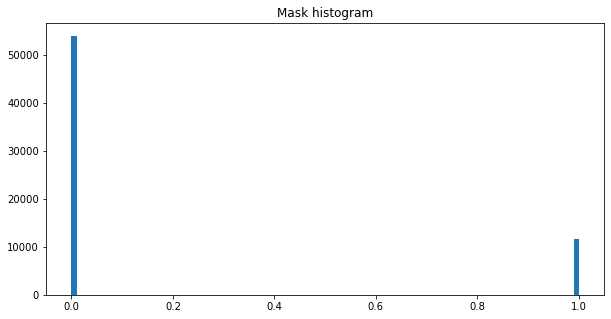

In [13]:
plt.hist(np.ravel(np.real(mask)), bins=100)
plt.title("Mask histogram")
plt.show()

Creating mask (./mask_logan_r6_c20.npy)...
(256, 256)
complex128
Creating mask (./mask_logan_r12_c20.npy)...
(256, 256)
complex128
Creating mask (./mask_logan_r6_c10.npy)...
(256, 256)
complex128
Creating mask (./mask_logan_r12_c10.npy)...
(256, 256)
complex128


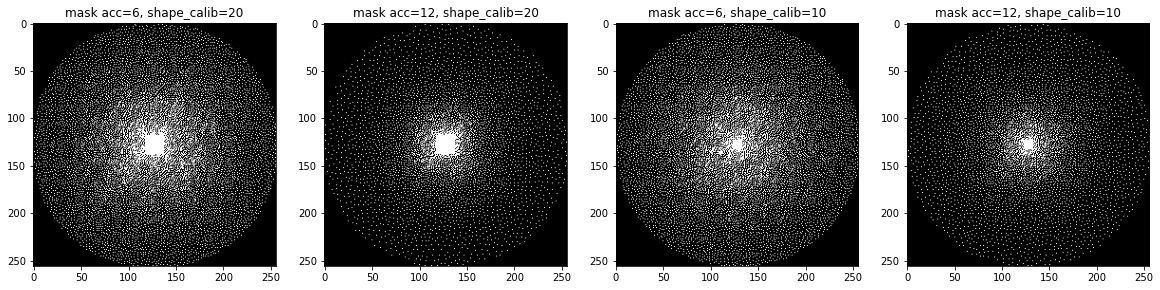

In [14]:
vals = [
    (6, 20),
    (12, 20),
    (6, 10),
    (12, 10),
]
plt.figure(figsize=(20,30))
for i, (acc, shape_calib) in enumerate(vals):
    plt.subplot(1,len(vals),1+i)
    plt.imshow(np.abs(make_poisson_mask(acc, shape_calib)), cmap="gray")
    plt.title(f"mask acc={acc}, shape_calib={shape_calib}")

The acceleration rate `acc` changes how far the mask spreads (how much high frequencies are kept), when higher the mask spreads less.

The calibration shape `shape_calib` changes how the mask looks in the center (at low frequencies), when higher the mask is more filled with ones in the middle.

**3.2.** Create a sampled phantom dataset by applying a sampling mask created with an acceleration of 6 and a calibration shape of 20.

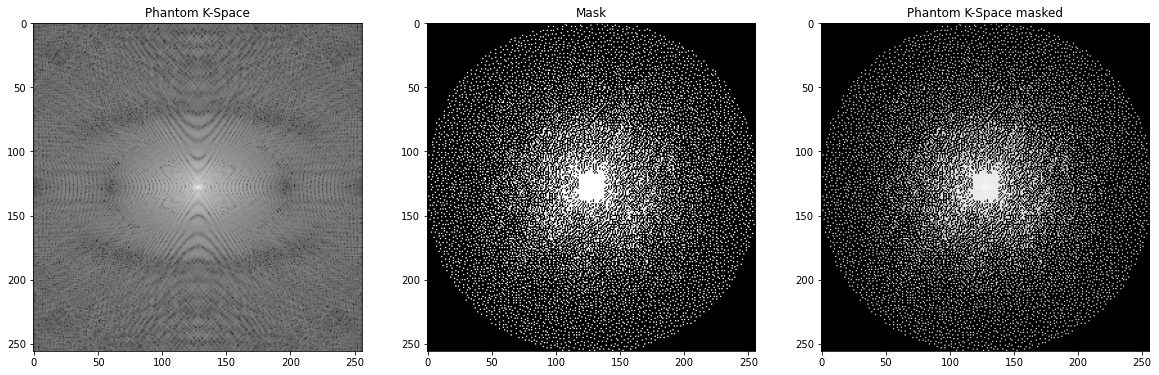

In [15]:
ksp_phantom_masked = np.multiply(mask, ksp_phantom[0,:,:])
plt.figure(figsize=(20,30))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(ksp_phantom[0,:,:])+1e-16), cmap="gray")
plt.title("Phantom K-Space")
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(mask)+1e-16), cmap="gray")
plt.title("Mask")
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(ksp_phantom_masked)+1e-16), cmap="gray")
plt.title("Phantom K-Space masked")
plt.show()

#### Direct Reconstruction from sampled data

**3.3.** **Reconstruction from sampled data:**  Reconstruct the MR image with the direct method (ifft) considering non sampled coefficients to be zero. What do you observe?

0.002332923962194161


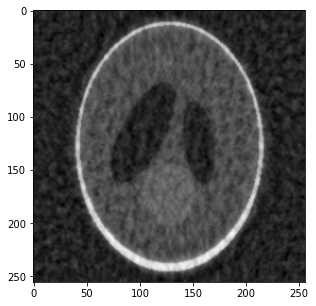

In [16]:
ksp_phantom_masked_ifft = sp.ifft(ksp_phantom_masked, axes=(-1,-2))
print(np.var(np.imag(ksp_phantom_masked_ifft)))
ksp_phantom_masked_ifft = np.real(ksp_phantom_masked_ifft)
plt.imshow(ksp_phantom_masked_ifft, cmap="gray")

The result is very degraded compared to the original image with all points being sampled

####  L1 and Wavelet reconstructions of phantom data

**3.4.** Use the **Wavelets + L1** method from the sigpy mri.apps to reconstruct the **sampled** phantom dataset. What is the criteria being optimized?

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.0008566622384367374


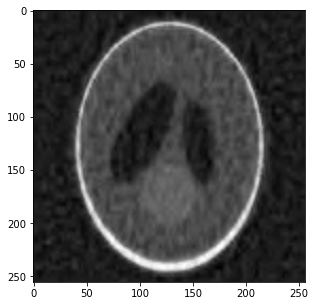

In [17]:
mps_phantom = np.ones((1, 256, 256))
lamda = 0.1

app = mr.app.L1WaveletRecon(ksp_phantom_masked, mps_phantom, lamda)
ksp_phantom_masked_L1WaveletRecon = app.run()

print(np.var(np.imag(ksp_phantom_masked_L1WaveletRecon)))
ksp_phantom_masked_L1WaveletRecon = np.real(ksp_phantom_masked_L1WaveletRecon)

plt.imshow(ksp_phantom_masked_L1WaveletRecon, cmap="gray")
plt.show()

The criteria being optimized is $$ f(x) = \frac{1}{2} \| P F S x - y \|_2^2 + \lambda \| W x \|_1 $$

With x being the space-domain image being optimized, and y the Kspace image.

**3.5.** Find the optimal lambda parameter by trial-and-error, choosing the value of lambda that maximizes the PSNR with respect to the fully sampled data. 

1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


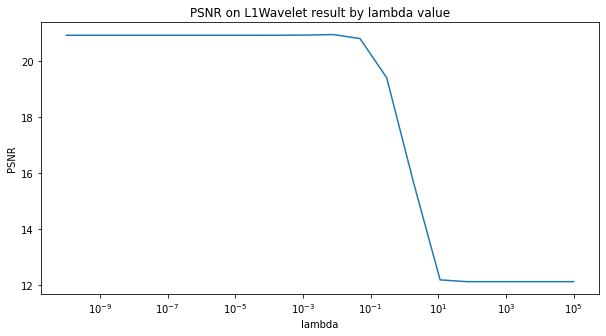

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


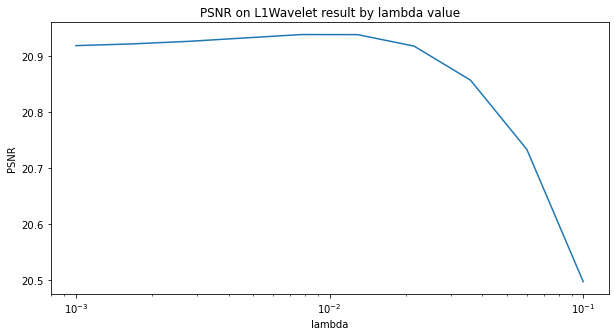

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


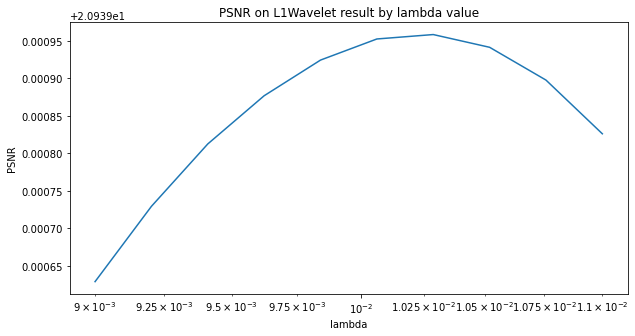

In [18]:
def show(la):
    lambda_vals = []
    psnr_vals = []

    for i, lamda in enumerate(la):
        print(1+i, "/", len(la))
        app = mr.app.L1WaveletRecon(ksp_phantom_masked, mps_phantom, lamda, show_pbar=False)
        res = app.run()
        res = np.real(res)
        lambda_vals.append(lamda)
        psnr_vals.append(PSNR(phantom_rec, res))

    plt.plot(lambda_vals, psnr_vals)
    plt.title("PSNR on L1Wavelet result by lambda value")
    plt.xlabel("lambda")
    plt.ylabel("PSNR")
    plt.xscale("log")
    plt.show()

show(np.logspace(-10, 5, 20))
show(np.logspace(-3, -1, 10))
show(np.logspace(np.log10(9e-3), np.log10(1.1e-2), 10))

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 0 -> PSNR = 20.913087452890554


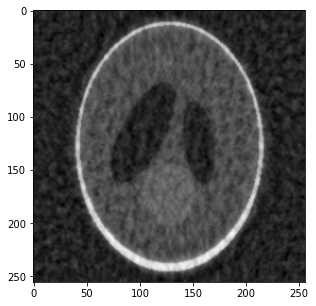

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 0.01 -> PSNR = 20.939947001359403


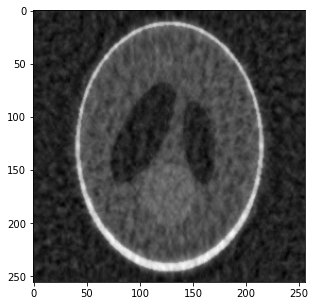

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 100000.0 -> PSNR = 12.131081815228377


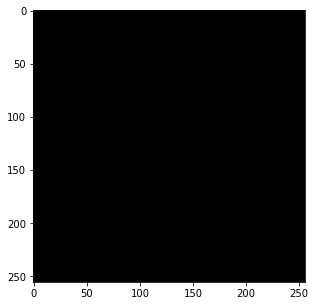

In [19]:
for lamda in (0, 1e-2, 1e5):
    app = mr.app.L1WaveletRecon(ksp_phantom_masked, mps_phantom, lamda)
    res = app.run()
    res = np.real(res)
    print("lambda =", lamda, "-> PSNR =", PSNR(phantom_rec, res))
    plt.imshow(res, cmap="gray")
    plt.show()

In [20]:
print("After simply ifft, PSNR =", PSNR(phantom_rec, ksp_phantom_masked_ifft))

After simply ifft, PSNR = 20.91308745289055


The best PSNR is achieved for lambda near 10^-2, with a PSNR of 20.939947001359403

That is not much better than lambda = 0 (PSNR = 20.913087452890554) which corresponds to just doing the inverse Fourier transform

**3.6.** Discuss how the reconstruction from the full dataset compares to the sampled dataset

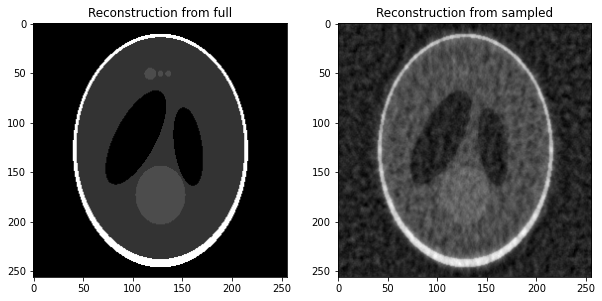

In [21]:
plt.subplot(1,2,1)
plt.imshow(phantom_rec, cmap="gray")
plt.title("Reconstruction from full")
plt.subplot(1,2,2)
plt.imshow(ksp_phantom_masked_ifft, cmap="gray")
plt.title("Reconstruction from sampled")
plt.show()

We can still see the main structures that are big enough, but not the small details like the three smallest dots.

## 4. Compressed Sensing on invivo/brain

For the invivo brain dataset we only have access to the sampled data (no full acquisition). However, different to the phantom, this dataset is multi-parallel and can make use of sensitivity maps for reconstruction.

**4.1.** Reconstruct the MR image using the direct reconstruction for each channel. What do you observe?

(8, 230, 180)


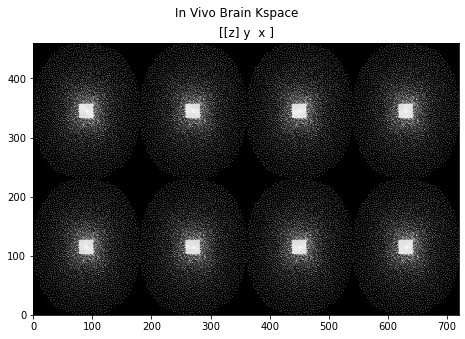

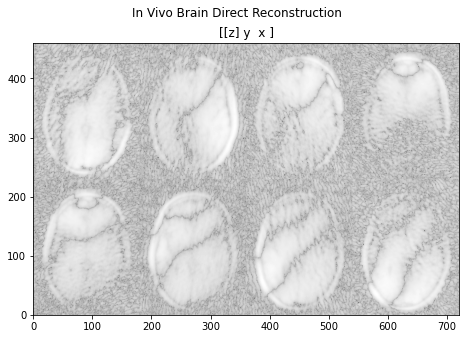

In [22]:
rec_direct = sp.ifft(ksp, axes=(-1,-2))
rec_direct = np.real(rec_direct)
print(rec_direct.shape)
pl.ImagePlot(np.log(np.abs(ksp)+1e-16), z=0, title='In Vivo Brain Kspace', interpolation="antialiased")
pl.ImagePlot(np.log(np.abs(rec_direct)+1e-16), z=0, title='In Vivo Brain Direct Reconstruction', interpolation="antialiased")

**4.2.** Single reconstruction from a mutiparallel acquisition

   a) Describe how multiparallel MRI data differs from traditional MRI?

Multiparallel MRI aquires several Kspace images instead of one like traditional MRI.

   b) Use the **Root-Sum-of-Squares reconstruction (RSS)** to recover a single MR image from the multichannel and sampled dataset. Consider the non sampled coefficients to be zero. 

$$
    I_{\rm RSS} = 
    \sqrt{
    \sum_{n=1}^{N {\rm channels}} IFFT(ksp)^2
    }
$$

(230, 180)


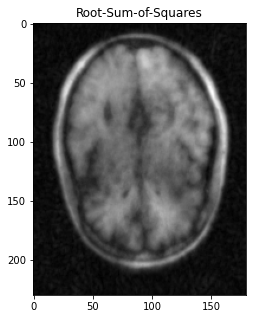

In [23]:
rec_rss = np.sqrt(np.sum(np.square(rec_direct), axis=0))
print(rec_rss.shape)
plt.imshow(rec_rss, cmap="gray")
plt.title("Root-Sum-of-Squares")
plt.show()

#### Sensitivity maps

To perform parallel imaging reconstruction of the multi-parallel data, we will use the ESPIRiT method to estimate first the sensitivity maps. To do this, we can use the [EspiritCalib](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.EspiritCalib.html#sigpy.mri.app.EspiritCalib) App from sigpy.

To run an App, you simply do `app.run()`. You should be able to see a progress bar showing the `App`'s progress.

**4.3.** Reconstruction with **sensitivity maps**

   a) What is a sensitivity map?, what are sensitivity maps useful for?

A sensitivity map indicates which parts of a measured Kspace image are more sensitive for the coils

They are useful in the optimization problem to take into account the different weights of each acquisition

   b) Compute and display the **sensitivity maps** for the in-vivo brain dataset using the ESPIRIT app from sigpy. What do you observe?

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

(1, 256, 256)


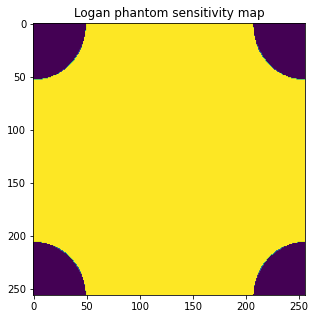

In [24]:
mps_phantom = mr.app.EspiritCalib(ksp_phantom).run()
print(mps_phantom.shape)
plt.imshow(np.real(mps_phantom[0,:,:]))
plt.title("Logan phantom sensitivity map")
plt.show()

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

(8, 230, 180)
0.03177487 1.7885273e-17
0.012246743 0.029571528
0.022330958 0.03501441
0.04774854 0.036638953
0.0579178 0.040768243
0.03928926 0.040065095
0.050990634 0.054569084
0.041123047 0.0142886415


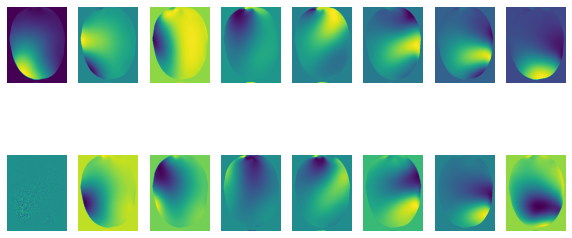

In [25]:
# Sensitivity maps

mps = mr.app.EspiritCalib(ksp).run()
print(mps.shape)
for i in range(mps.shape[0]):
    print(np.var(np.real(mps[i,:,:])), np.var(np.imag(mps[i,:,:])))
    plt.subplot(2,mps.shape[0],1+i)
    plt.imshow(np.real(mps[i,:,:]))
    plt.axis("off")
    plt.subplot(2,mps.shape[0],1+mps.shape[0]+i)
    plt.imshow(np.imag(mps[i,:,:]))
    plt.axis("off")
plt.show()

We observe that each Kspace image is more sensitive in a different area, so it makes sense to combine them

Note: the resulting sensitivity maps are complex (and the imaginary part is not tiny)

   c) Use the mri.apps to do the reconstruction of the **brain dataset** using the SENSE method using the computed sensitivity maps

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.04522594
0.04936877


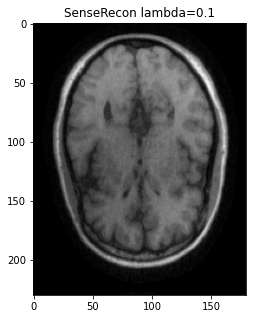

In [26]:
def runSenseRecon(lamda = 0.1):
    app = mr.app.SenseRecon(ksp, mps, lamda)
    rec_SenseRecon = app.run()
    print(np.var(np.real(rec_SenseRecon)))
    print(np.var(np.imag(rec_SenseRecon)))
    rec_SenseRecon = np.abs(rec_SenseRecon)
    plt.imshow(rec_SenseRecon, cmap="gray")
    plt.title("SenseRecon lambda=" + str(lamda))
    plt.show()
    return rec_SenseRecon
rec = runSenseRecon()

Note: the resulting image is complex (and the imaginary part is not tiny)

   d) Look at the documentation, what criteria is being optimized here?

The criteria being optimized is
$$ f(x) = \frac{1}{2} \| P F S x - y \|_2^2 + \frac{\lambda}{2} \| x \|_2^2 $$

   e) Change the regularization parameters of each method and discuss how they change the qualitative results

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.0812815
0.08672486


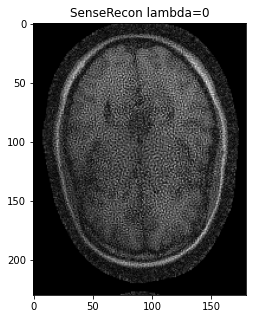

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.07089623
0.076520994


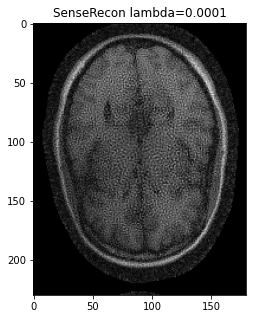

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.059192527
0.06496614


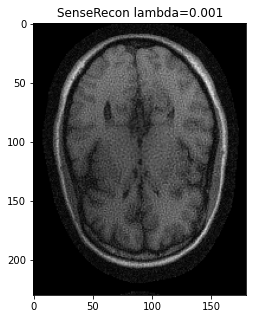

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.055158634
0.060712524


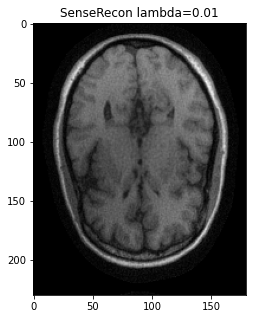

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.04522594
0.04936877


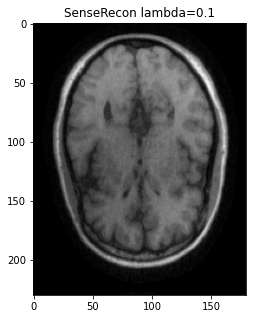

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.0132561475
0.014233372


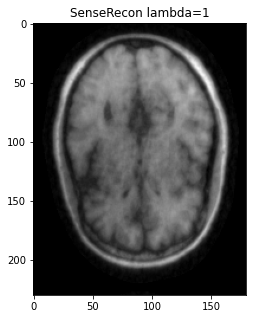

In [27]:
runSenseRecon(0)
runSenseRecon(0.0001)
runSenseRecon(0.001)
runSenseRecon(0.01)
runSenseRecon(0.1)
rec = runSenseRecon(1)


lambda = 0.01 seems to look best just from looking at it

It is not too blurry like with bigger lambda values, and not too noisy/artefacted like with the smaller lambda values

#### Reconstructions

**4.4.** **Regularized reconstructions**

   a) Use the mri.apps to do the reconstruction of the **brain dataset** using the following methods
        - Wavelet L1 Reconstruction
        - Total Variation Reconstruction

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.056459505
0.062279865


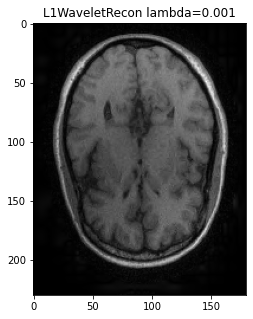

In [28]:
def runL1WaveletRecon(lamda = 0.001):
    app = mr.app.L1WaveletRecon(ksp, mps, lamda)
    rec = app.run()
    print(np.var(np.real(rec)))
    print(np.var(np.imag(rec)))
    rec = np.abs(rec)
    plt.imshow(rec, cmap="gray")
    plt.title("L1WaveletRecon lambda=" + str(lamda))
    plt.show()
    return rec
rec = runL1WaveletRecon()

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.055468697
0.061024506


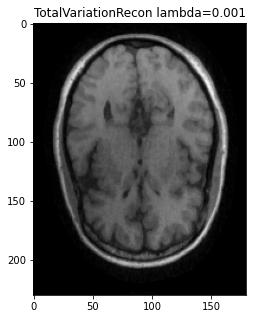

In [29]:
def runTotalVariationRecon(lamda = 0.001):
    app = mr.app.TotalVariationRecon(ksp, mps, lamda)
    rec = app.run()
    print(np.var(np.real(rec)))
    print(np.var(np.imag(rec)))
    rec = np.abs(rec)
    plt.imshow(rec, cmap="gray")
    plt.title("TotalVariationRecon lambda=" + str(lamda))
    plt.show()
    return rec
rec = runTotalVariationRecon()

   b) Look at the documentation of each method and explain the problem solved in each case. 

L1WaveletRecon: $$ f(x) = \frac{1}{2} \| P F S x - y \|_2^2 + \lambda \| W x \|_1 $$

With the regularization assuming a sparse wavelet transform (W being the wavelet operator)

TotalVariationRecon: $$ f(x) = \frac{1}{2} \| P F S x - y \|_2^2 + \lambda \| G x \|_1 $$

With the regularization assuming a sparse gradient of the image (nearby pixels being close to the same)

   c) Change the regularization parameters of each method and discuss how they change the qualitative results

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.06322799
0.069054075


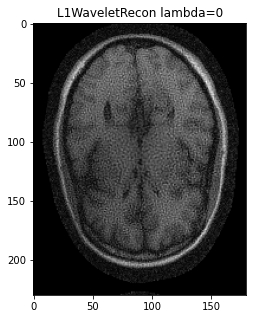

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.059911825
0.0657241


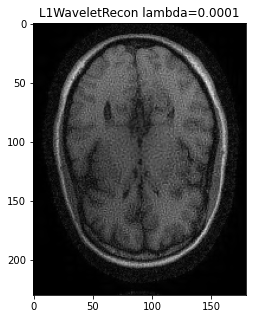

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.0564595
0.06227986


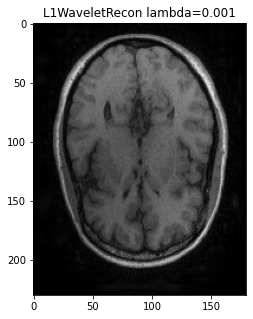

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.05533219
0.060935006


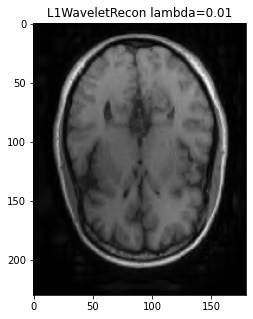

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.05182424
0.056263007


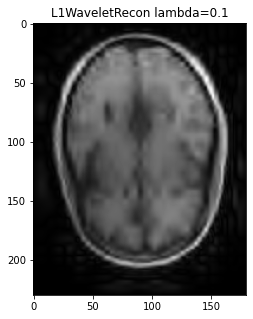

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.035851233
0.037511434


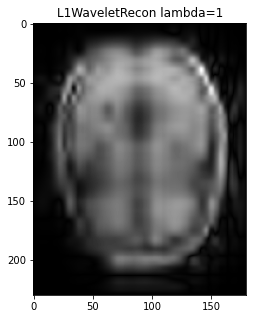

In [30]:
runL1WaveletRecon(0)
runL1WaveletRecon(0.0001)
runL1WaveletRecon(0.001)
runL1WaveletRecon(0.01)
runL1WaveletRecon(0.1)
rec = runL1WaveletRecon(1)

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.055640534
0.061214138


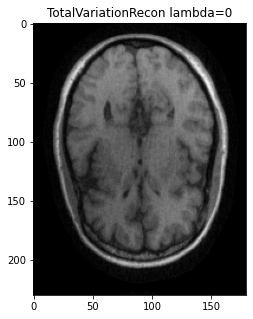

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.055619527
0.06119161


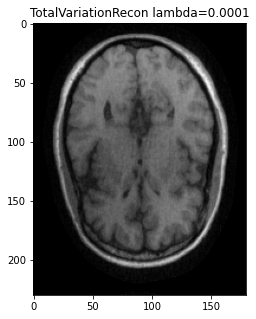

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.05546809
0.061023563


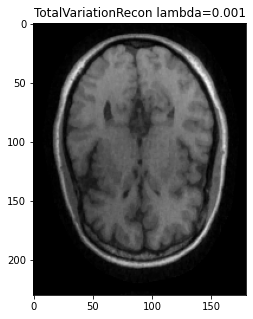

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.054691505
0.060044106


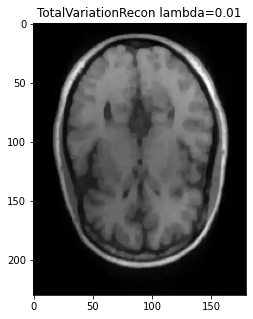

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.050656173
0.054509833


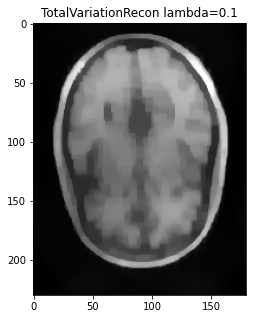

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.03585949
0.037420068


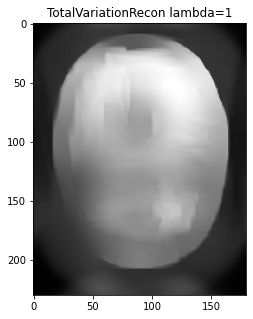

In [31]:
runTotalVariationRecon(0)
runTotalVariationRecon(0.0001)
runTotalVariationRecon(0.001)
runTotalVariationRecon(0.01)
runTotalVariationRecon(0.1)
rec = runTotalVariationRecon(1)

L1WaveletRecon: best lambda seems to be around 0.001 (not too blurry, not too artefacted)

TotalVariationRecon: best lambda seems to be around 0.001 (not too blurry, not too artefacted)

# Final comparison

We compare the three different methods applied to the in vivo brain mri, with refined lambda values:

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.054377113
0.059822556


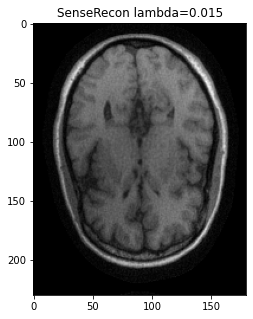

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.0564595
0.06227985


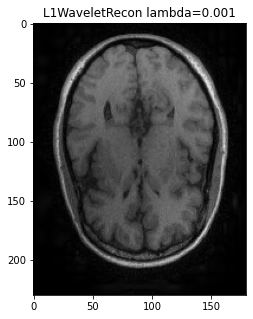

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

0.055528406
0.061091628


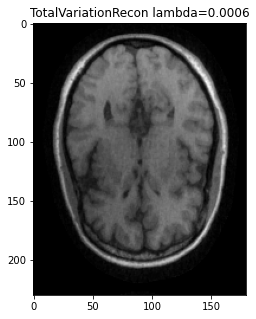

Text(0.5, 1.0, 'TotalVariation lambda=0.0006')

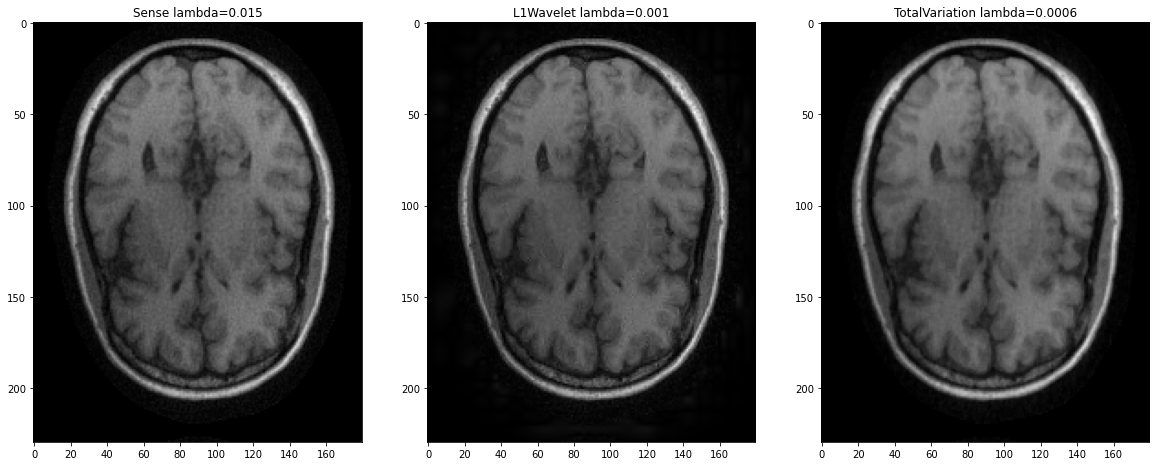

In [32]:
lambda_SenseRecon_final = 0.015
lambda_L1WaveletRecon_final = 0.001
lambda_TotalVariationRecon_final = 0.0006

rec_SenseRecon_final = runSenseRecon(lambda_SenseRecon_final)
rec_L1WaveletRecon_final = runL1WaveletRecon(lambda_L1WaveletRecon_final)
rec_TotalVariationRecon_final = runTotalVariationRecon(lambda_TotalVariationRecon_final)

plt.figure(figsize=(20,30))
plt.subplot(1,3,1)
plt.imshow(rec_SenseRecon_final, cmap="gray")
plt.title(f"Sense lambda={lambda_SenseRecon_final}")
plt.subplot(1,3,2)
plt.imshow(rec_L1WaveletRecon_final, cmap="gray")
plt.title(f"L1Wavelet lambda={lambda_L1WaveletRecon_final}")
plt.subplot(1,3,3)
plt.imshow(rec_TotalVariationRecon_final, cmap="gray")
plt.title(f"TotalVariation lambda={lambda_TotalVariationRecon_final}")